<a href="https://colab.research.google.com/github/tancik/learnit/blob/main/meta_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Image Regression Demo
### Learned Initializations for Optimizing Coordinate-Based Neural Representations
[Project Website](https://www.matthewtancik.com/learnit)

[arXiv](https://arxiv.org/abs/2012.02189)

In [ ]:
!pip install -q optax
!pip install -q git+https://github.com/deepmind/dm-haiku

In [ ]:
from functools import partial
import jax
from jax import random, grad, jit, vmap, flatten_util, nn
import optax
from jax.config import config
import jax.numpy as np
import haiku as hk
import pickle

# from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm as tqdm

# Data

In [ ]:
def process_example(example, RES):
    image = np.float32(example["image"]) / 255
    return image[:,image.shape[1]//2-RES//2:image.shape[1]//2+RES//2,image.shape[2]//2-RES//2:image.shape[2]//2+RES//2]

In [ ]:
batch_size = 3 #@param {type:"integer"}
RES = 178
num_val_exs = 5

gcs_base_dir = "gs://celeb_a_dataset/"
builder = tfds.builder("celeb_a", data_dir=gcs_base_dir, version='2.0.0')
builder.download_and_prepare()

ds = builder.as_dataset(split='train', as_supervised=False, shuffle_files=True, batch_size=3)
ds = ds.take(-1)

ds_val = builder.as_dataset(split='validation', as_supervised=False, shuffle_files=False, batch_size=1)
ds_val = ds_val.take(num_val_exs)

# Setup Network

In [ ]:
class SirenLayer(hk.Module):
    def __init__(self, in_f, out_f, w0=200, is_first=False, is_last=False):
        super().__init__()
        self.w0 = w0
        self.is_first = is_first
        self.is_last = is_last
        self.out_f = out_f
        self.b = 1 / in_f if self.is_first else np.sqrt(6 / in_f) / w0

    def __call__(self, x):
        x = hk.Linear(output_size=self.out_f, w_init=hk.initializers.RandomUniform(-self.b, self.b))(x)
        return x + .5 if self.is_last else self.w0 * x

class Siren_Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.w0 = 200
        self.width = 256
        self.depth = 5        
        
    def __call__(self, coords):
        sh = coords.shape
        x = np.reshape(coords, [-1,2])
        x = SirenLayer(x.shape[-1], self.width, is_first=True, w0=self.w0)(x)
        x = np.sin(x)
        
        for _ in range(self.depth-2):
            x = SirenLayer(x.shape[-1], self.width, w0=self.w0)(x)
            x = np.sin(x)
            
        out = SirenLayer(x.shape[-1], 3, w0=self.w0, is_last=True)(x)
        out = np.reshape(out, list(sh[:-1]) + [3])
        return out

# Training steup

In [ ]:
# @jit
# @partial(jit, static_argnums=[6])
def outer_step(rng, image, coords, params, inner_steps, opt_inner):
    def loss_fn(params, rng_input):
        g = model.apply(params, coords)
        return mse_fn(g, image)
    
    image = np.reshape(image, (-1,3))
    coords = np.reshape(coords, (-1,2))
    opt_inner_state = opt_inner.init(params)
    loss = 0
    for _ in range(inner_steps):
        rng, rng_input = random.split(rng)
        loss, grad = jax.value_and_grad(loss_fn)(params, rng_input)

        updates, opt_inner_state = opt_inner.update(grad, opt_inner_state)
        params = optax.apply_updates(params, updates)
    return rng, params, loss

outer_step_batch = vmap(outer_step, in_axes=[0, 0, None, None, None, None])

# @partial(jit, static_argnums=[6])
def update_model(rng, params, opt_state, image, coords, inner_steps, opt_inner):
    if reptile:
        rng = random.split(rng, batch_size)
        rng, new_params, loss = outer_step_batch(rng, image, coords, params, inner_steps, opt_inner)
        rng, loss = rng[0], np.mean(loss)
        new_params = jax.tree_map(lambda x: np.mean(x, axis=0), new_params)
        def calc_grad(params, new_params):
            return params - new_params

        model_grad = jax.tree_multimap(calc_grad, params, new_params)
    else:
        def loss_model(params, rng):
            rng = random.split(rng, batch_size)
            rng, new_params, loss = outer_step_batch(rng, image, coords, params, inner_steps, opt_inner)
            g = vmap(model.apply, in_axes=[0,None])(new_params, coords)
            return mse_fn(g[:,0,...], image), rng[0]
        (loss, rng), model_grad = jax.value_and_grad(loss_model, argnums=0, has_aux=True)(params, rng)

    updates, opt_state = opt_outer.update(model_grad, opt_state)
    params = optax.apply_updates(params, updates)
    return rng, params, opt_state, loss

# Train Model

Here is an example meta training procedure. You can try both MAML and Reptile.
The MAML model reported in the paper was trained for 150K iterations. In the next section you can directly download this checkpoint.

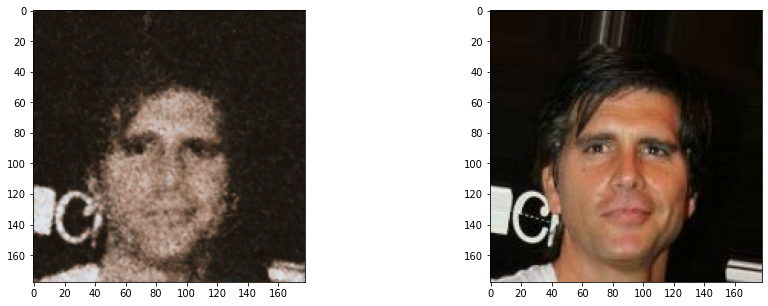

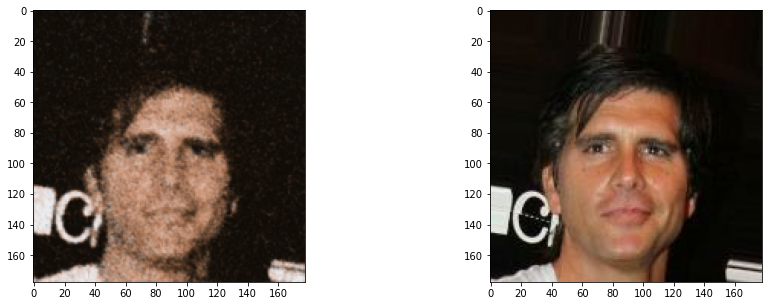

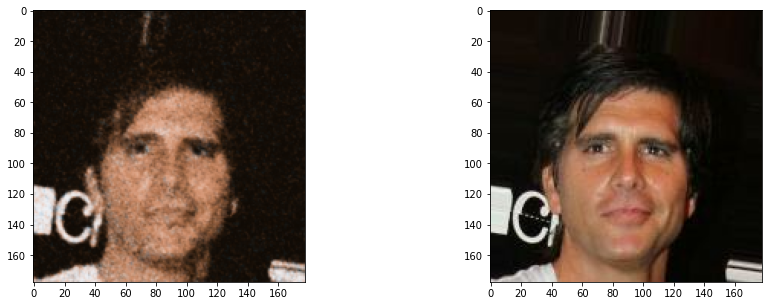

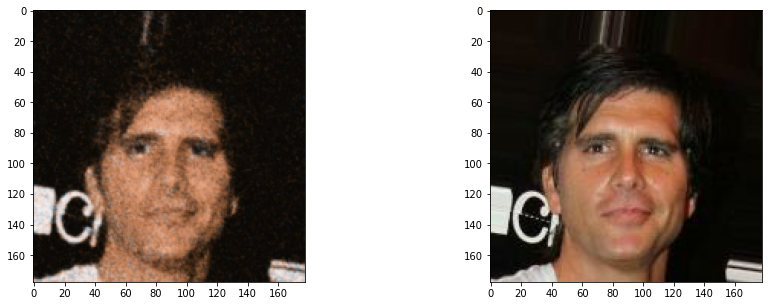

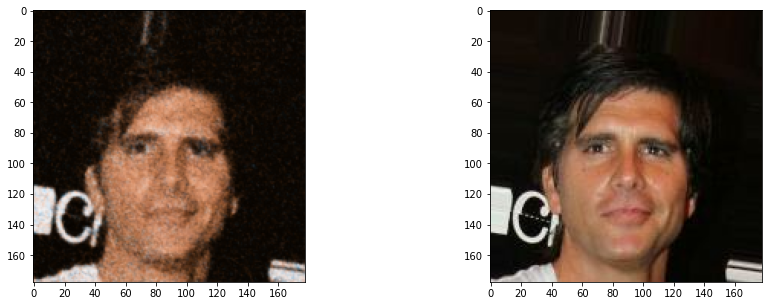

In [ ]:
meta_method = "MAML" #@param ["MAML", "REPTILE"]

max_iters = 1000 #@param {type:"integer"}

reptile = meta_method == 'REPTILE'

outer_lr = 1e-5 #@param
inner_lr = .01 #@param
inner_steps = 2 #@param {type:"integer"}

x1 = np.linspace(0, 1, RES+1)[:-1]
coords = np.stack(np.meshgrid(x1,x1, indexing='ij'), axis=-1)[None,...]

model = hk.without_apply_rng(hk.transform(lambda x: Siren_Model()(x)))
params = model.init(random.PRNGKey(0), np.ones((1,2)))

opt_outer = optax.adam(outer_lr)
opt_inner = optax.sgd(inner_lr)

opt_state = opt_outer.init(params)

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda mse: -10 * np.log10(mse))

train_psnrs = []
train_psnr = []
val_psnrs = []
steps = []
step = 0
rng = random.PRNGKey(0)
rng_test = random.PRNGKey(42)
while step < max_iters:
    for example in tqdm(tfds.as_numpy(ds), leave=False, desc='iter'):
        if step > max_iters:
            break

        image = process_example(example, RES)

        rng, params, opt_state, loss = update_model(rng, params, opt_state, image, coords, inner_steps, opt_inner)
        train_psnr.append(psnr_fn(loss))

        if step % 200 == 0 and step != 0:
            train_psnrs.append(np.mean(np.array(train_psnr)))
            train_psnr = []
            val_psnr = []
            for val_example in tfds.as_numpy(ds_val):
                val_img = process_example(val_example, RES)
                _, params_test, loss = outer_step(rng_test, val_img, coords, params, inner_steps, opt_inner)
                img = model.apply(params_test, coords)[0]
                val_psnr.append(psnr_fn(mse_fn(img, val_img)))
            val_psnrs.append(np.mean(np.array(val_psnr)))

            plt.figure(figsize=(15,5))        
            plt.subplot(1,2, 1)
            plt.imshow(np.clip(img, 0, 1))
            plt.subplot(1,2, 2)
            plt.imshow(val_img[0])
            plt.show()
            steps.append(step)
        step += 1

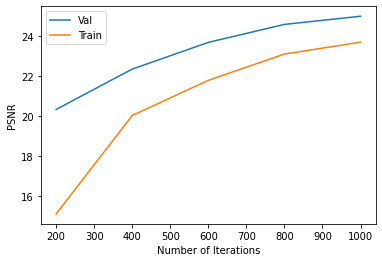

In [ ]:
plt.plot(steps, val_psnrs, label='Val')
plt.plot(steps, train_psnrs, label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Number of Iterations')
plt.show()

# Or load checkpoint!

In [ ]:
if not os.path.exists('maml_ilr_0.01_olr_1e-05_bs_3_150000.pkl'):
    !wget https://people.eecs.berkeley.edu/~tancik/learnit/checkpoints/maml_ilr_0.01_olr_1e-05_bs_3_150000.pkl

with open(f'maml_ilr_0.01_olr_1e-05_bs_3_150000.pkl', 'rb') as file:
    params = pickle.load(file)

# Evaluate learned weights

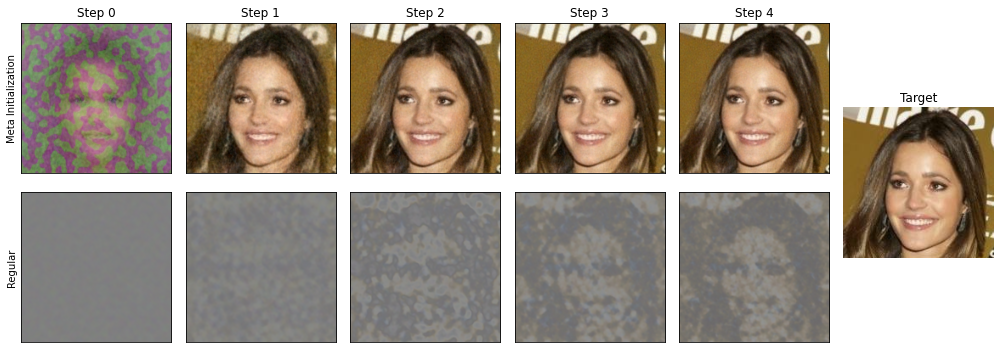

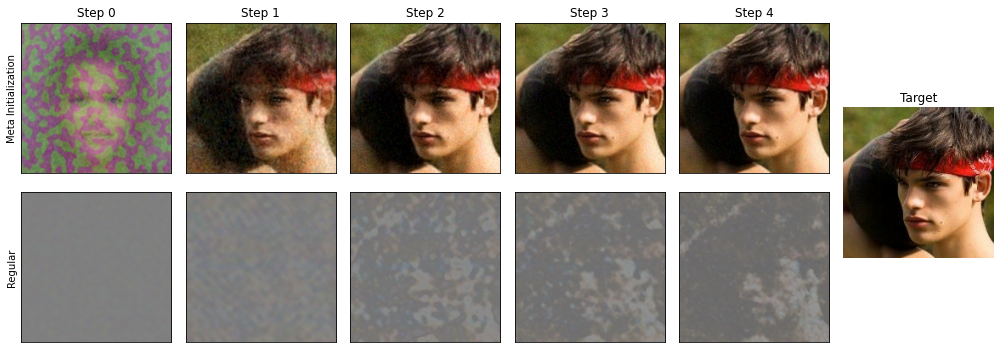

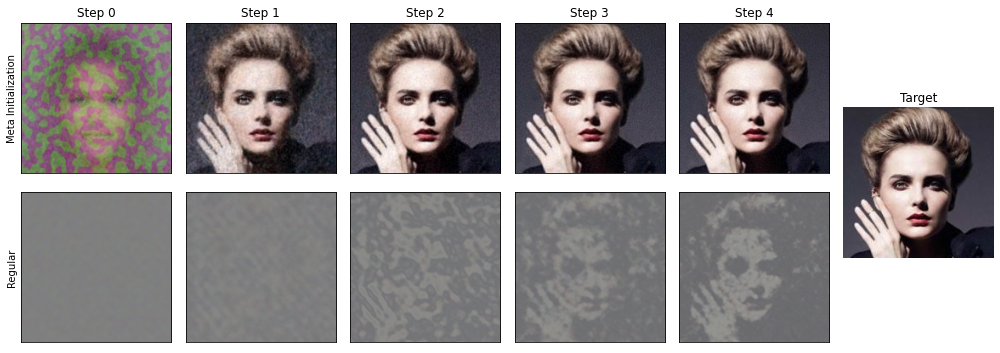

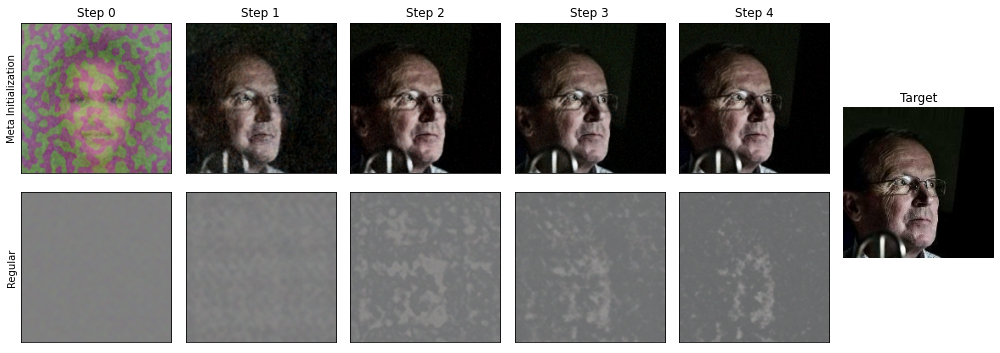

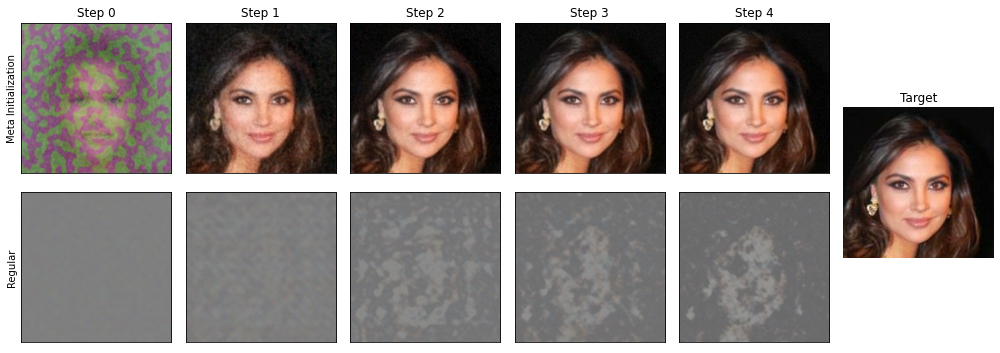

In [ ]:
meta_opt_inner = optax.sgd(1e-2)
nonmeta_opt_inner = optax.adam(1e-4)

max_steps = 5
num_examples = 5

params_non_meta = model.init(random.PRNGKey(0), np.ones((1,2)))

ds_test = builder.as_dataset(split='test', as_supervised=False, shuffle_files=False, batch_size=1)
ds_test = ds_test.take(num_examples)
for i, example in tqdm(enumerate(tfds.as_numpy(ds_test))):
    test_img = process_example(example, RES)
    plt.figure(figsize=(14,5))
    for i in range(max_steps):
        _, params_test, _ = outer_step(rng_test, test_img[None,...], coords, params, i, meta_opt_inner)
        render = model.apply(params_test, coords)[0]
        plt.subplot(2,max_steps+1,i+1)
        plt.imshow(np.clip(render,0,1))
        plt.yticks([])
        plt.xticks([])
        if i == 0:
            plt.ylabel('Meta Initialization')
        plt.title(f'Step {i}')

        _, params_test, _ = outer_step(rng_test, test_img[None,...], coords, params_non_meta, i, nonmeta_opt_inner)
        render = model.apply(params_test, coords)[0]
        plt.subplot(2,max_steps+1,i+2+max_steps)
        plt.imshow(np.clip(render,0,1))
        plt.yticks([])
        plt.xticks([])
        if i == 0:
            plt.ylabel('Regular')
    plt.subplot(1,max_steps+1,max_steps+1)
    plt.imshow(test_img[0])
    plt.title('Target')
    plt.axis('off')
    plt.tight_layout()  
    plt.show()